### rOMERO-gateway Overview
![Overview](romero_overview.png)

### Load rOMERO-gateway

In [17]:
library(romero.gateway)

### Connect to the server

In [19]:
server <- OMEROServer(host = 'outreach.openmicroscopy.org', username='username', password='password', port= as.integer(4064))
server <- connect(server)

## Read Data from OMERO

### OMERO dataset and Annotation details

In [20]:
datasetName <- 'CellProfiler images'
fileName <- 'Cells.csv'

### Find the dataset and get the attachment

In [21]:
searchResult <- searchFor(server, Dataset, 'Name', datasetName)
omeDataset <- searchResult[[1]]
print(paste('Dataset ID:',omeDataset@dataobject$getId()))

# Find the attached csv file
fileAnnotation <- getAnnotations(server, 'DatasetData', getOMEROID(omeDataset), nameFilter = fileName)
annotationFileID = as.integer(fileAnnotation$FileID)
print(paste('Annotation ID:', annotationFileID))

# Get Image Names
images <- getImages(omeDataset)
image_names <- c()
for (image in images){
    image_names <- c(image_names, image@dataobject$getName())
}

[1] "Dataset ID: 602"
[1] "Annotation ID: 26029"


### Load annotation as a R-Dataframe and compare cell areas between the two sets of images

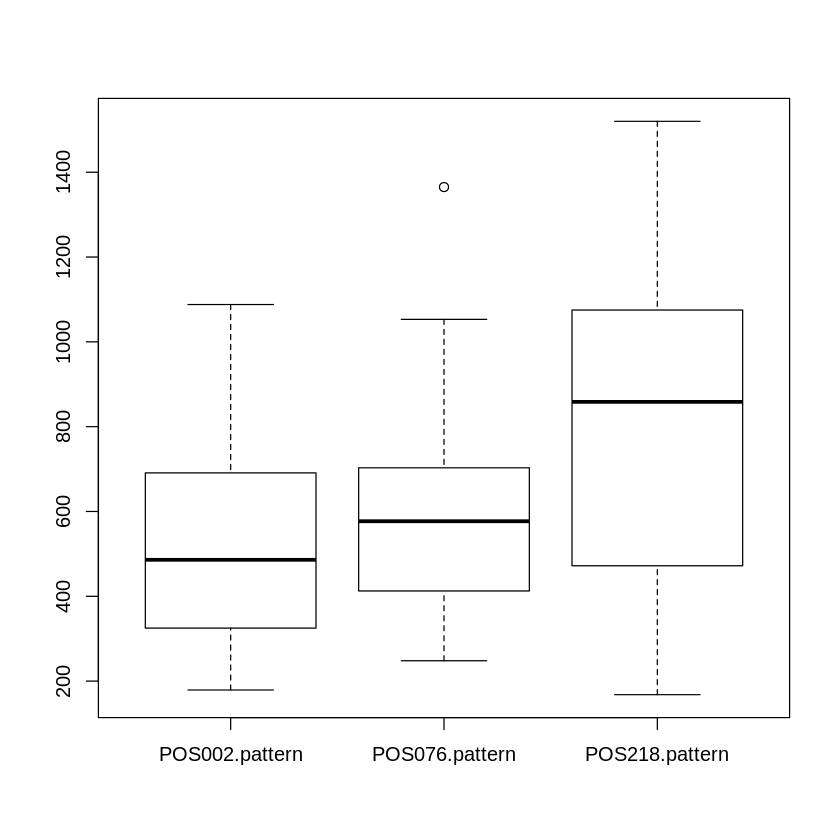

In [22]:
df <- loadCSV(server, annotationFileID)
dfLength <- subset(df, select=c("ImageNumber", "AreaShape_Area"))
boxplot(dfLength$AreaShape_Area~dfLength$ImageNumber)

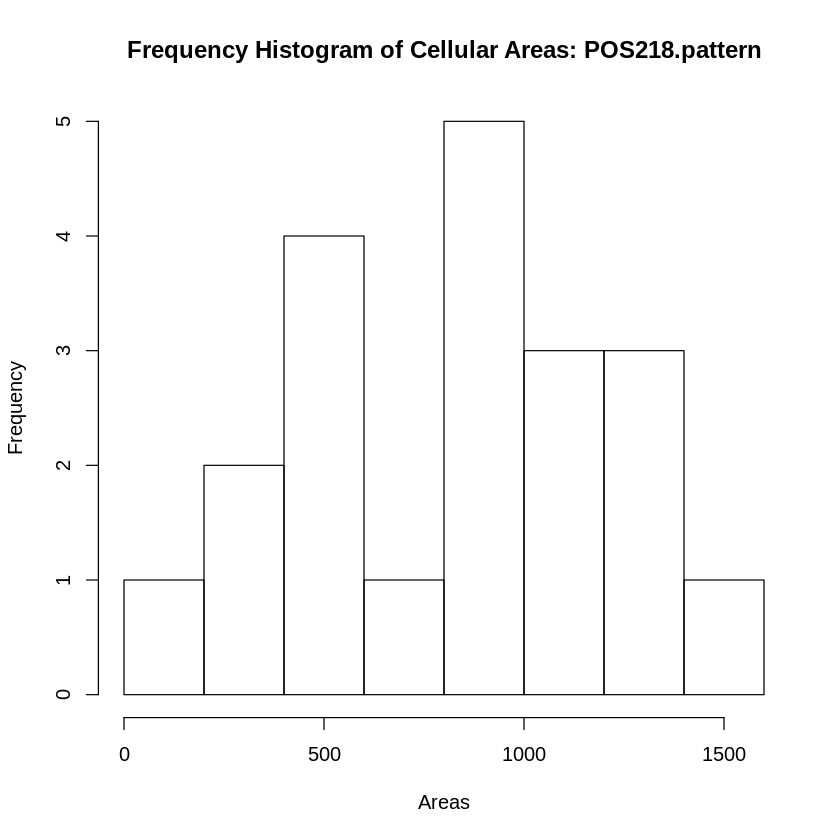

In [23]:
Areas = subset(dfLength, dfLength$ImageNumber == image_names[[1]])$AreaShape_Area
hist(Areas, main = paste("Frequency Histogram of Cellular Areas:",image_names[[1]]))

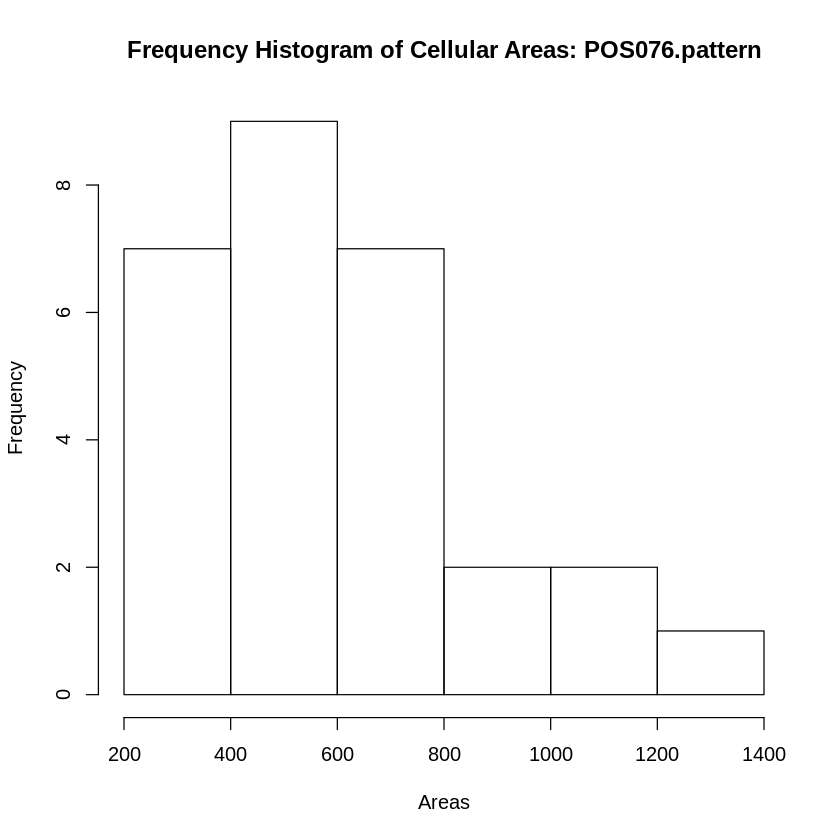

In [24]:
Areas = subset(dfLength, dfLength$ImageNumber == image_names[[2]])$AreaShape_Area
hist(Areas, main = paste("Frequency Histogram of Cellular Areas:",image_names[[2]]))

## Save Results back to OMERO

### Attach the plot to an OMERO dataset 

In [25]:
# Attach the plot to the dataset
tmpfile <- "/tmp/boxplot.png"
png(tmpfile)
boxplot(dfLength$AreaShape_Area~dfLength$ImageNumber)
dev.off()
omero_attach_plot <- attachFile(omeDataset, tmpfile)

print(paste("OMERO File Annotation ID:", omero_attach_plot@dataobject$getId()))

png 
  2

[1] "OMERO File Annotation ID: 599"


### Attach the t-test output to the dataset

In [27]:
Areas_2 <- subset(dfLength, dfLength$ImageNumber == image_names[[1]] | dfLength$ImageNumber == image_names[[2]])

t.test(Areas_2$AreaShape_Area~Areas_2$ImageNumber)
tmpfile <- "/tmp/ttest_summary.txt"
cat("Here are my results:\n", file=tmpfile)
capture.output(t.test(Areas_2$AreaShape_Area~Areas_2$ImageNumber), file=tmpfile, append=TRUE)
omero_attach_file <- attachFile(omeDataset, tmpfile)

print(paste("OMERO File Annotation ID:", omero_attach_file@dataobject$getId()))


	Welch Two Sample t-test

data:  Areas_2$AreaShape_Area by Areas_2$ImageNumber
t = -2.097, df = 30.081, p-value = 0.04451
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -419.193111   -5.564032
sample estimates:
mean in group POS076.pattern mean in group POS218.pattern 
                    601.5714                     813.9500 


[1] "OMERO File Annotation ID: 601"


### Disconnect OMERO session

In [28]:
server_disconnect <- disconnect(server)